IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from xgboost import XGBRegressor

In [2]:
df = pd.read_excel(r"D:\DOKUMEN PKL PLN\DATA SPKLU JUN24 - JUN25.xlsx")

In [3]:
df.tail(5)

,NO,NOAGENDA,UNITUP,ID_SPKLU,NAMA_SPKLU,PEMKWH,RP_PERKWH,RP_KWH,RP _SHARING_REVENUE,RP_PPN,RP_PPJ,RP_MATERAI,RP_TOTAL,RP_PLN_PARTNER,TGL_BAYAR,TGL_LUNAS,JENIS_INSTALASI
3798,3799,SPKLU535632506300769,53563,1448,SPKLU PLN TRANS,104,1645,170218,59576.0,0.0,15320,0,245114,0,30/06/2025,30/06/2025,INSTALASI BARU
3799,3800,SPKLU535632506300770,53563,1448,SPKLU PLN TRANS,81,1645,132512,46379.0,0.0,11926,0,190817,0,30/06/2025,30/06/2025,INSTALASI BARU
3800,3801,SPKLU535632506300771,53563,1448,SPKLU PLN TRANS,128,1645,210270,73594.0,0.0,18924,0,302788,0,30/06/2025,30/06/2025,INSTALASI BARU
3801,3802,SPKLU535632506300772,53563,1448,SPKLU PLN TRANS,86,1645,141820,49637.0,0.0,12764,0,204221,0,30/06/2025,30/06/2025,INSTALASI BARU
3802,3803,SPKLU535632506300773,53563,1448,SPKLU PLN TRANS,18,1645,29291,10252.0,0.0,2636,0,42179,0,30/06/2025,30/06/2025,INSTALASI BARU


PREPROCESSING DATA

In [6]:
df.isnull().sum()

NO                        0
NOAGENDA                  0
UNITUP                    0
ID_SPKLU                  0
NAMA_SPKLU                0
PEMKWH                    0
RP_PERKWH                 0
RP_KWH                    0
RP _SHARING_REVENUE    3631
RP_PPN                 3631
RP_PPJ                    0
RP_MATERAI                0
RP_TOTAL                  0
RP_PLN_PARTNER            0
TGL_BAYAR                 0
TGL_LUNAS                 0
JENIS_INSTALASI        3631
dtype: int64

In [4]:
df['TGL_BAYAR'] = pd.to_datetime(df['TGL_BAYAR'], dayfirst=True)

daily = df.groupby('TGL_BAYAR', as_index=False)[['RP_TOTAL']].sum()
daily.columns = ['ds', 'pendapatan']

In [5]:
missing_days = pd.date_range(daily['ds'].min(), daily['ds'].max()).difference(daily['ds'])
print("Jumlah hari tanpa transaksi:", len(missing_days))

Jumlah hari tanpa transaksi: 260


In [7]:
s = (daily.set_index('ds')
           .asfreq('D')['pendapatan']
           .fillna(0))

SPLIT DATA

In [8]:
n_test = 30
train_series = s.iloc[:-n_test]
test_series  = s.iloc[-n_test:]

In [9]:
# SARIMA 
sarima = auto_arima(train_series, seasonal=True, m=7,
                    stepwise=True, suppress_warnings=True,
                    error_action='ignore')
sarima_fc = pd.Series(sarima.predict(n_periods=n_test), index=test_series.index)

# XGBoost Regressor
df_feat = s.to_frame(name='pendapatan').copy()
for lag in [1, 2, 7]:
    df_feat[f'lag_{lag}'] = df_feat['pendapatan'].shift(lag)
df_feat = df_feat.dropna()

split_point = len(df_feat) - n_test
train_xgb, test_xgb = df_feat.iloc[:split_point], df_feat.iloc[split_point:]

Xtr, ytr = train_xgb.drop(columns=['pendapatan']), train_xgb['pendapatan']
Xte, yte = test_xgb.drop(columns=['pendapatan']), test_xgb['pendapatan']

xgb = XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=5,
    random_state=42, objective='reg:squarederror', n_jobs=-1
)
xgb.fit(Xtr, ytr)
xgb_fc = pd.Series(xgb.predict(Xte), index=yte.index)


In [10]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) /
                         (np.abs(y_pred) + np.abs(y_true) + 1e-9))

def safe_mape(y_true, y_pred):
    yt = pd.Series(y_true).replace(0, np.nan)
    return float(np.mean(np.abs((yt - y_pred) / yt)) * 100)

for name, y_true, y_pred in [
    ("SARIMA", test_series, sarima_fc),
    ("XGBoost", yte, xgb_fc),
]:
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | "
          f"sMAPE: {smape(y_true, y_pred):.2f}% | MAPE: {safe_mape(y_true, y_pred):.2f}%")

SARIMA -> MAE: 9,199,631.93 | RMSE: 12,455,013.59 | sMAPE: 156.04% | MAPE: 60.29%
XGBoost -> MAE: 9,443,495.88 | RMSE: 14,042,989.78 | sMAPE: 167.61% | MAPE: 68.14%


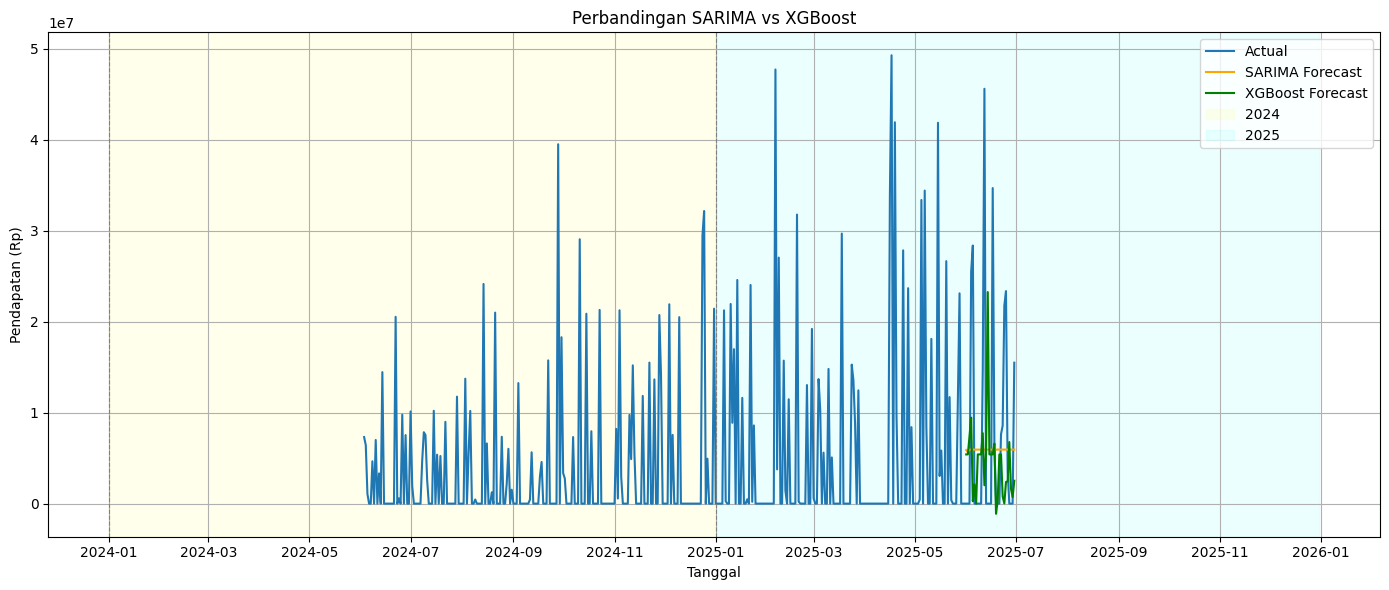

In [11]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(s.index, s.values, label='Actual')
ax.plot(sarima_fc.index, sarima_fc.values, label='SARIMA Forecast', color='orange')
ax.plot(xgb_fc.index, xgb_fc.values, label='XGBoost Forecast', color='green')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Highlight 2024 & 2025 (sesuaikan jika perlu)
ax.axvspan(pd.Timestamp('2024-01-01'), pd.Timestamp('2024-12-31'),
           alpha=0.08, color='yellow', label='2024')
ax.axvspan(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'),
           alpha=0.08, color='cyan', label='2025')
for y in [2024, 2025]:
    ax.axvline(pd.Timestamp(f'{y}-01-01'), color='gray', ls='--', lw=0.8)

ax.set_title('Perbandingan SARIMA vs XGBoost')
ax.set_xlabel('Tanggal'); ax.set_ylabel('Pendapatan (Rp)')
ax.grid(True); ax.legend()
plt.tight_layout(); plt.show()

Kesimpulan

Preprocessing yang dilakukan adalah menambahkan data yang tidak ada transaksi dengan fillna(0) menyesuaikan data real dibandingkan dilakukan interpolasi

Berdasarkan test model menggunakan SARIMA dan XGboost 
- MAE & RMSE pada SARIMA lebih rendah daripada XGBoost yang menandakan rata-rata error

Pada data ini, SARIMA sedikit unggul pada metrik error dibanding XGBoost, tapi selisihnya tidak besar.

Tingginya MAPE & sMAPE pada kedua model menunjukkan pola data yang intermittent (banyak nol + lonjakan acak) memang sulit dimodelkan.